# $\textit{Cancelación activa de ruido}$
$\textit{By }$

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import scipy.io as io
import helper as hp
import importlib
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio
from ipywidgets import IntProgress
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
elecBackITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/electronic_backend/PANDAR_TF_201_backend_dSPACE.ita")
acousticPathsITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/acoustic_booth/persons/PANDAR_TF_001_person_BoseQC20.ita")

fs = 48000

In [ ]:
elecBack = elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14].T        # Direct, Lowcut, AAF, PreAmp En este orden estan las resp impulsivas

display(elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16])
display(elecBack.shape)

In [ ]:
acousticPaths = acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14].T   # SecL, SecR, FeedBL, FeedBR, primL, PrimR

acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16]

In [ ]:
_, Voice = io.wavfile.read("Voice.wav")
_, Song = io.wavfile.read("Song.wav")
_, Street = io.wavfile.read("ruidoCalle.wav")
Song = Song.T
Street = Street.T

Noisesong = np.random.normal(0, 0.05, Song.shape)
Noisevoice = np.random.normal(0, 0.05, Voice.shape)

NoisepSong = Song + Noisesong
NoisepVoice = Voice + Noisevoice

In [ ]:
Audio(NoisepSong, rate=fs)


In [ ]:
plt.figure()

plt.plot(acousticPaths[4])
plt.plot(acousticPaths[0])
print(len(acousticPaths[0]))

In [82]:
def fxlms_sim(w0, mu, P, S, S_hat, xgen, sound, orden_filtro, N = 10000):
    w = w0
    J = np.zeros(N)
    e = np.zeros(N)
    xf_corr = np.zeros(orden_filtro)

    zip = np.zeros(np.max([len(P[0]), len(P[1])])-1)
    zis = np.zeros(np.max([len(S[0]), len(S[1])])-1)
    zis_hat = np.zeros(np.max([len(S_hat[0]), len(S_hat[1])])-1)
    ziw = np.zeros(orden_filtro-1)

    f = IntProgress(min=0, max=N)
    display(f)
    i = 0
    for n in range(N):
    
        x = xgen(n)
    
        d, zip = sp.lfilter(P[0], P[1], [x], zi=zip)

        xf, zis_hat = sp.lfilter(S_hat[0], S_hat[1], [x], zi=zis_hat)
        xf_corr[1:] = xf_corr[:-1]
        xf_corr[0] = xf[0]
        
        y, ziw = sp.lfilter(w, [1], [x], zi=ziw)

        y = y[0] + sound(n)

        d_hat, zis = sp.lfilter(S[0], S[1], [y], zi=zis)
        e[n] = d[0] + d_hat[0]
        J[n] = e[n] * e[n]
        w = w - mu * xf_corr * e[n] / (np.linalg.norm(xf_corr)**2 + 1e-6)
        if n//(N//100) > i:
            f.value = n
            i += 1

    return w, J, e        


In [93]:

x = lambda n: np.random.normal(0, 2)
x = lambda n: Street[0][n]*10 + np.random.normal(0, 1)

sound = lambda n: 0.1*np.sin(2*np.pi*160/fs*n)
sound0 = lambda n: 0

w_order = 10000
wo = np.zeros(w_order)
mu = 0.02
P = ([ 0, 0, 0, 0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )
P = ([ 0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0, 1], [1] )
P = (np.concatenate([[],acousticPaths[4]]), [1])

# S = ([ 0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
#         0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
#        -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
#         0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
#        -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
#         0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
#        -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
#         0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
#         0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
#        -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )
S = (np.concatenate([[],acousticPaths[0]]), [1])
# S = ([1], [1])

S_hat = S

w, J, e = fxlms_sim(wo, mu, P, S, S_hat, x, sound0, w_order, N = fs*20)
display(w)



IntProgress(value=0, max=960000)

array([6.18104176e+13, 5.60442112e+13, 5.37515921e+13, ...,
       3.42029334e+14, 3.47951964e+14, 3.54616398e+14])

In [34]:
display(acousticPaths[4])
display(w)


array([-0.0046926 , -0.00425463,  0.00441719, ...,  0.00264161,
       -0.00043981, -0.00036964])

array([-6.00970739e-04,  4.02980448e-03,  3.87826204e-03, ...,
       -9.15721540e-05, -1.26163855e-04, -3.42940222e-05])

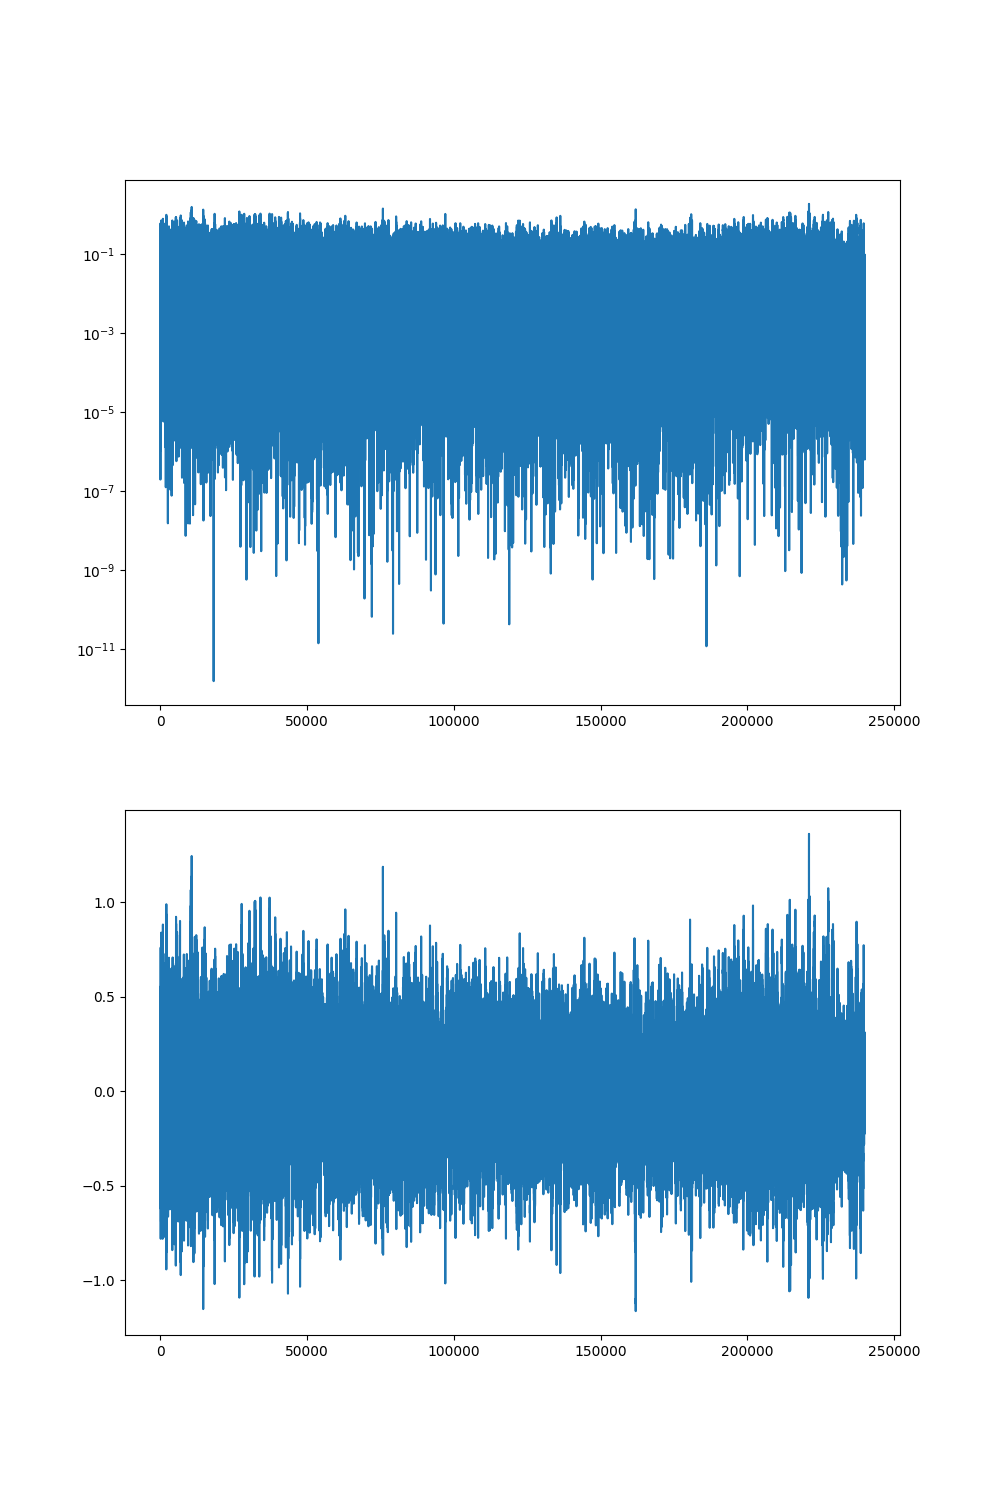

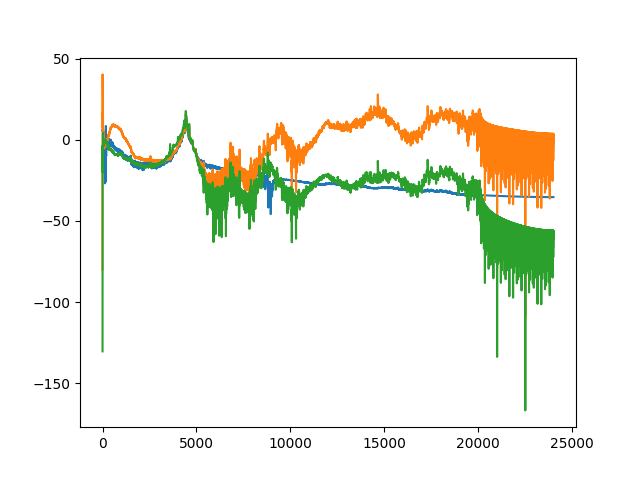

In [91]:
plt.figure(figsize=(10, 15))

plt.subplot(211)
plt.semilogy(J)

plt.subplot(212)
plt.plot(e)


freqs, s = sp.freqz(P[0], S[0], fs=fs, worN=10000)
freqp, p = sp.freqz(P[0], P[1], fs=fs, worN=10000)
freqw, w = sp.freqz(w, [1], fs=fs, worN=10000)
plt.figure()

plt.subplot(111)
plt.plot(freqw, 20*np.log10(np.abs(w)))
plt.plot(freqs, 20*np.log10(np.abs(s)))
plt.plot(freqp, 20*np.log10(np.abs(p)))


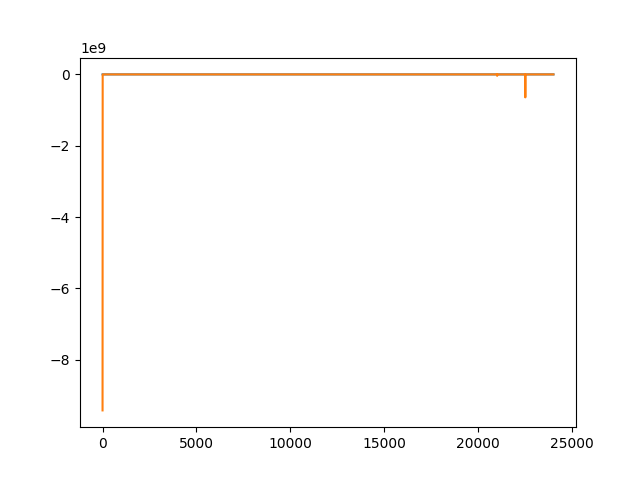

In [78]:

freqs, s = sp.group_delay(S, fs=fs, w=10000)
freqp, p = sp.group_delay(P, fs=fs, w=10000)
plt.figure()

plt.subplot(111)

plt.plot(freqs, s)
plt.plot(freqp, p)

In [79]:
noisandsound = sound(np.linspace(0, fs*5, fs*5)) + [x(i) for i in range(fs*5)]
display(Audio(e, rate=fs))
display(Audio(noisandsound, rate=fs))
io.wavfile.write('filtered.wav', rate=fs, data=e)
io.wavfile.write('raw.wav', rate=fs, data=noisandsound)


In [ ]:
freq, p = sp.periodogram(e, fs=fs, window='hann')
freqs, ps = sp.periodogram(noisandsound, fs=fs, window='hann')
plt.figure()
plt.semilogy(freqs, ps)
plt.semilogy(freq, p)

In [ ]:
# Define the filter parameters
order = 100  # Filter order
cutoff_freq = 15000  # Cutoff frequency as a fraction of the Nyquist frequency (0.0 to 1.0)
sampling_freq = 48000  # Sampling frequency

# Design the FIR filter
taps = sp.firwin(order, cutoff=cutoff_freq, fs=sampling_freq, pass_zero=True)
# Design the minimum-phase filter from the linear-phase filter
min_phase_taps = sp.minimum_phase(taps)
display(min_phase_taps)
# Compute the frequency response of the filter
w, h = sp.freqz(min_phase_taps, worN=8000)

# Plot the frequency response
plt.close()
plt.figure()
plt.plot(0.5 * sampling_freq * w / np.pi, 20*np.log(abs(h)))
plt.title('FIR Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid()
plt.show()